<a href="https://colab.research.google.com/github/ShawnPei/LLM-detect/blob/main/LLM_detect_AI_Generated_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM - Detect AI Generated Text  

xp2087 Xiongyu Pei, tg2523 Tim Guo

This is an ongoing competition, aiming to detect whether an essay is written by human or by LLMs.
We are going to use BERT to complete this task.

## Exploring the training dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_names = ["real", "fake"]  # real: written by human, fake: written by LLMs
num_classes = len(class_names)  # Number of classes: 2
class_labels = list(range(num_classes))  # labels are 0, 1
label2name = dict(zip(class_labels, class_names))  # 0 corresponds to real, 1 corresponds to fake
name2label = {v: k for k, v in label2name.items()}  # real -> 0, fake -> 1

Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')
Training data: 1378
Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


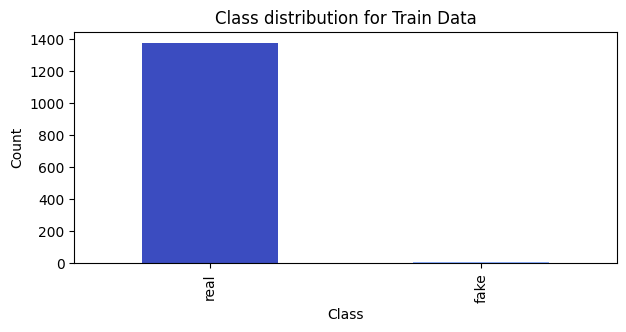

In [ ]:
cmap = mpl.colormaps.get_cmap('coolwarm')

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/NLP/llm-detect-ai-generated-text/train_essays.csv')  # Read CSV file into a DataFrame

# To check what fields does this file have
print(df.columns) # Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')

# Add two new columns
df['label'] = df.generated.copy()
df['name'] = df.generated.map(label2name)  # Map answer labels using name-to-label mapping

# Display information about the train data
print(f"Training data: {len(df)}")
print("Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(7,3))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()


As we can see from above, there is no LLM generated essays in the training dataset, so we will have to includ some external dataset to help us training our model.

## Adding external dataset

Thanks to the selfless contribution of dataset, we will use following dataset:

* DAIGT Proper Train Dataset@thedrcat:https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/, we use the train_drcat_04.csv.


In [ ]:
# Load external data
DAIGT_df = pd.read_csv('/content/drive/MyDrive/NLP/train_drcat_04.csv')

print(DAIGT_df.columns)
print(len(DAIGT_df))

Index(['essay_id', 'text', 'label', 'source', 'prompt', 'fold'], dtype='object')
44206


There are 44,206 data in the dataset, but according to the its description, the distribution of LLMs used is not even, we will take a look into the distribution of LLMs used.

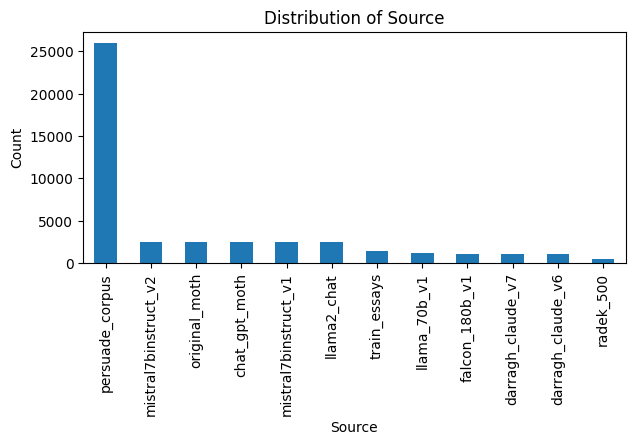

In [ ]:
# Count the frequency of each source
source_counts = DAIGT_df['source'].value_counts()

# Create a bar plot of the source distribution
plt.figure(figsize=(7,3))
source_counts.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Distribution of Source')
plt.show()

It is clearly imbalance, in order to eliminate potential bias, we will reorganize the data, so that number of essays generated by persuade_corpus will be less dominant.

Training data: 28210
Sample:


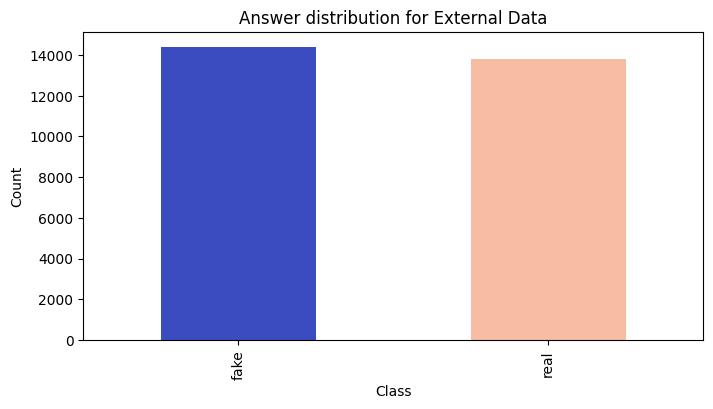

In [ ]:
custom_df = pd.concat([
    # DAIGT_df[DAIGT_df.source=='persuade_corpus'].sample(18210),
    DAIGT_df[DAIGT_df.source=='persuade_corpus'].sample(10000),
    DAIGT_df[DAIGT_df.source!='persuade_corpus']
])

custom_df['name'] = custom_df.label.map(label2name)

# Display information about the external data
print(f"Training data: {len(custom_df)}")
print("Sample:")
custom_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
custom_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()


This will give us a additional 28210 data to train our model.
And now we will concat external data to give training data

In [ ]:
df = pd.concat([df, custom_df]).reset_index(drop=True)
df.head()

# Display information about the train data
print(f"Training data: {len(df)}")
print("Sample:")
df.head(2)

# Show distribution of answers using a bar plot
# plt.figure(figsize=(8, 4))
# df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25)])
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.title("Class distribution for Train Data")
# plt.show()


Training data: 29588
Sample:


,id,prompt_id,text,generated,label,name,essay_id,source,prompt,fold
0,0059830c,0.0,Cars. Cars have been around since they became ...,0.0,0,real,NaN,NaN,NaN,NaN
1,005db917,0.0,Transportation is a large necessity in most co...,0.0,0,real,NaN,NaN,NaN,NaN


Now the dataset is ready, we are ready to do some training.

## Train the model

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
texts = df['text'].tolist()
labels = df['label'].tolist()

# Split the data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5)

# Tokenize the texts
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Prepare the inputs for the model

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)
test_dataset = Dataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Load the pre-trained model and add a classification layer
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}


# Create the trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Print the device of the first parameter of the model
print(next(model.parameters()).device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0


In [ ]:
trainer.train()

Step,Training Loss
500,0.174200
1000,0.070100
1500,0.034200
2000,0.021300
2500,0.021100
3000,0.009100
3500,0.007300


TrainOutput(global_step=3885, training_loss=0.043944308625838625, metrics={'train_runtime': 2825.07, 'train_samples_per_second': 21.993, 'train_steps_per_second': 1.375, 'total_flos': 8230596880693248.0, 'train_loss': 0.043944308625838625, 'epoch': 3.0})

In [ ]:
# Save the model
trainer.save_model("llm_detect_distillBERT")

In [ ]:
# Load the saved model
our_model = DistilBertForSequenceClassification.from_pretrained("llm_detect_distillBERT")

# Create a new trainer with the loaded model
our_trainer = Trainer(
    model=model,
    args=training_args,  # Use the same training arguments as before
    compute_metrics=compute_metrics  # Use the same compute_metrics function as before
)

# Define a dictionary to map label indices to label names
label_dict = {0: 'real', 1: 'fake'}  # Replace with your actual labels

# Get the predictions
predictions, _, _ = our_trainer.predict(test_dataset)

# Convert the predictions to labels
predicted_labels = np.argmax(predictions, axis=1)



In [ ]:
# Print the texts, true labels, and predicted labels
for i in range(100,105):
    print(f'❓ Text {i + 1}:')
    print(test_texts[i])
    print(f'✅ True: {label_dict[test_labels[i]]}')
    print(f'🤖 Predicted: {label_dict[predicted_labels[i]]}')
    print()

❓ Text 101:
Alice had been feeling stuck in her life for years, unable to find the motivation to make a meaningful change. That all changed, however, when she heard about a person who had faced similar struggles, but had managed to turn their life around and achieve their dreams. Hearing their story inspired Alice to go out and make the changes she wanted, and the results were astonishing. She was suddenly filled with newfound confidence and self-belief, and was able to make astounding progress in her life. Alice realized that anything is possible with dedication and perseverance, and she was so glad she had the opportunity to learn from the experiences of others.
✅ True: fake
🤖 Predicted: fake

❓ Text 102:
I think students would benefit from being able to attend classes from home. Distance learning is a great alternative to traditional classroom learning as it offers students the flexibility to learn at their own pace and in their own space.

One of the benefits of distance learning i

In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

print(f'Test Accuracy: {accuracy}')



Test Accuracy: 0.9941428249605767
